## Approximation of linear and non-linear ODE's through IMPLICIT methods.
-------
### Introduction and objective
Exact and analytic solutions are of great educational, academic, theoretical, comprehension and validation value, but their quantitative results for a given practical problem at hand are at best approximate due to an inevitable mismatch between ideal theory and observable reality. 

In practice, when quantitative results for a given real-world problem are required, the numerically approximate estimation may often be demonstrably better (more accurate, faster, comprehensive, correct, exhaustive, efficient, cost-effective, etc.) than the analytical.

Our aim will be to Implement two implicit solvers, the Backward Euler method and Crank Nicholson (Midpoint method), to later study the convergence order and to compare the methods using a non-linear 2x2 ODE system. We will use the same system as in the previous projects to be able to compare the methods correctly.

In [1]:
# import the libraries needed for the hole assignment.
import numpy as np
from math import e
from matplotlib import pyplot as plt
from numpy import zeros, array, exp
from numpy.linalg import norm
import numpy as np

# Past Functions
def evolve(phi,f,Df, t0,y0, T,N):
    h = T/N
    y = np.zeros([N+1, len(y0)])
    y[0] = y0
    t = 0
    for i in range(N):
        y[i+1] = phi(f,Df, t,y[i], h)
        t = t+h
    return y

# Define The Ralston Method
# Note that we store the value of f(t0, y0) into the variable F, 
#to optimize the numbers of calls to the function from 2 to 1. 
def ralstonMethod(f,Df, t0,y0, h):
    F = f(t0, y0)
    F2 = f(t0 + (2*h)/3, y0 + (2/3)*h*F)
    return y0 + (h/4) * (F + 3*F2)

# Define the Forward Euler and Ralston method.
def forwardEuler( f,Df, t0,y0, h):
    return y0 + h*f(t0,y0)

def ralstonMethod(f,Df, t0,y0, h):
    F = f(t0, y0)
    F2 = f(t0 + (2*h)/3, y0 + (2/3)*h*F)
    return y0 + (h/4) * (F + 3*F2)

#EOC function
def computeEocs( herr ):
    # herr = ( (h1,e1),(h2,e2),...,(hm,em) )
    m = len(herr)
    eocs = np.zeros( m-1 )
    for i in range(m-1):
        eocs[i] = np.log(herr[i+1,1]/herr[i,1] ) /\
                  np.log(herr[i+1,0]/herr[i,0] );
    return eocs

### Solving the implicit problem with Newton-Raphson Algorithm. 
The main difference between explicit and implicit schemes is that the later ones require finding the root of an implcict equation to compute the value of $y_{n+1}$. To solve this issue we are going to implement a function that implements Newton-Raphson root finding Algorithm. The inputs will be, the vector valued function F,  its Jacobian, and the initial guess x0 are as arguments together with a tolerance ϵ. The Algorithm should return the first element xk in the sequence:
$$x_{k+1}=x_k−DF^{−1}(x_k)F(x_k)$$
which satisfies $|F(x_k)|<ϵ$ using the standard Euclidean norm.

Note: To avoid an infinite loop in case Newton's method does not converge stop the method after computing the first K iterates. In addition to $x_k$ also return the number k of iterations performed. So convergence of the method can be tested by checking $k<K$.

In [2]:
# Define the Newton Method.
def newton (F, DF, x0, eps, K):
    for k in range(K):
            fvec = F(x0)
            D = DF(x0)
            x = x0 - np.linalg.solve(D, fvec)
            if np.linalg.norm(fvec) < eps:
                return x, k
            x0 = x
            if k == K-1:
                return x, k+1

### Defining The Numerical schemes:Backward Euler Method Method and Crank Nicholson
To apply Newton's Algorithm to Backard Euler Method $y1$ we can for example define the function F as
$$F(δ)=δ−f(t_0+h,y_0+hδ)$$

so that $y_1=y_0+hδ$.For Newton's method you need the Jacobian of $F:R^m→R^m$, which by the Chain Rule.

$$DF(δ)=I_m−h∂yf(t_0+h,y_0+hδ)$$

where $I_m$ is the identity matrix. Following the same argument we can define $F$ and $DF$ as written in the implementation.

In [3]:
def midpointmethod( f_user,Df, t0,y0, h):
    F =  lambda delta: delta-f_user(t0+h/2,y0+(h*delta)/2)
    DF = lambda delta: np.eye(len(y0))-h*df_user(t0+h/2,y0+(h*delta)/2)
    delta,_ = newton(F,DF,f_user(t0+h,y0),h*h*1e-5,1000)
    return y0+h*delta

In [4]:
def backwardEuler( f,Df, t0,y0, h):
    # not good style but reduces polution of the global namespace when running the tests
    from numpy import eye
    F =  lambda delta: delta-f(t0+h,y0+h*delta)
    DF = lambda delta: eye(len(y0))-h*Df(t0+h,y0+h*delta)
    delta,_ = newton(F,DF,f(t0+h,y0),h*h*1e-5,1000)
    return y0+h*delta

### Setting Up the ODE Problem

 Problem setup for ODE
 $y'(t)=F(y(t))$ and $y(0)=y_0$ with right hand side
 $$ F(y_1,y_2) = \left(\begin{array}{cc} y_2 \\[1ex] y_2(\lambda-2y_1) \end{array}\right) $$
 With $\lambda=1$ and initial conditions $y_0=(2, -2)^T$ this has the exact solution
 $$ Y(t) = \left(\begin{array}{cc}
      \frac{2e^t}{2e^t-1} \\[2ex]
      \frac{-2e^{t}}{4e^{2t}-4e^t+1}
 \end{array}\right) $$
We will solve this on the interval $[0,T]$.

In [5]:
T = 1
Y = lambda t: array([2*exp(t)/(2*exp(t)-1),
                     (-2*exp(t))/(4*exp(2*t)-4*exp(t)+1)])
def f(t,y):
    return array([y[1], y[1]*(1-2*y[0])])
def Df(t,y):
    return array([[0,1],[2*y[1],1-2*y[0]]])

def df_user(t,y):
    return np.array([[1],[1-2*y[0]]])

Simulations and Errors 
-----------
 
Perform the simulation using the forwardEuler stepper

In [6]:
def experiment(stepper):
    M = 11
    herr = zeros( [M,2] )
    for m in range(M):
        N = 20*2**m
        y = evolve( stepper, f,Df, 0,Y(0),T, N)
        herr[m] = [T/N, norm( y[-1]-Y(T) )]

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )
    return res

In [7]:
resMID = experiment(midpointmethod)

In [8]:
resBE = experiment(midpointmethod)

In [9]:
res = np.hstack([resBE,resMID])
import pandas as pd
# columns of table
columns=['h', 'BE-error', 'BE-eoc', 'MID-error','MID-eoc']
# values in table
keys = {columns[0]: resBE[:,0], columns[1]: resBE[:,1], columns[2]: resBE[:,2],
                                columns[3]: resMID[:,1], columns[4]: resMID[:,2]}
# generate table
table = pd.DataFrame(keys, index=range(res.shape[0]),
        columns=columns)
# format floating points for each column
table = table.style.format({columns[0]:'{:.4e}',
                            columns[1]:'{:.6e}', columns[3]:'{:.6e}',
                            columns[2]:'{:.3f}', columns[4]:'{:.3f}'})
# print(table.to_latex()) # output result as latex table for inclusion in tex document
table

,h,BE-error,BE-eoc,MID-error,MID-eoc
0,5.0000e-02,5.731941e-04,nan,5.731941e-04,nan
1,2.5000e-02,1.431922e-04,2.001,1.431922e-04,2.001
2,1.2500e-02,3.579142e-05,2.000,3.579142e-05,2.000
3,6.2500e-03,8.947439e-06,2.000,8.947439e-06,2.000
4,3.1250e-03,2.236834e-06,2.000,2.236834e-06,2.000
5,1.5625e-03,5.592068e-07,2.000,5.592068e-07,2.000
6,7.8125e-04,1.398016e-07,2.000,1.398016e-07,2.000
7,3.9063e-04,3.495040e-08,2.000,3.495040e-08,2.000
8,1.9531e-04,8.737601e-09,2.000,8.737601e-09,2.000
9,9.7656e-05,2.184398e-09,2.000,2.184398e-09,2.000


In [10]:
# Set boundary conditions
T = 1
t_bar = 1/np.sqrt(2) 

In [11]:
def experiment(stepper):
    M = 11
    herr = zeros( [M,2] )
    for m in range(M):
        N = 20*2**m
        y = evolve( stepper, fint ,Df, 0,Y(0),T, N)
        herr[m] = [T/N, norm( y[-1]-exactsolq3(T) )]

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )
    return res

In [12]:
# Define the RHS of the ODE.
def fint(t,y):
    if t < t_bar:
        return (-y)
    elif t >= t_bar:
        return (y)

In [13]:
# Solving the ODE analytically.
def exactsolq3(t):
    if  t < t_bar:
        return (np.exp(-t))
    elif t >= t_bar:
        return (np.exp(-np.sqrt(2) + t))


In [14]:
resFE = experiment(forwardEuler)

In [15]:
resRalston = experiment(ralstonMethod)

Text(0, 0.5, 'Error at end time')

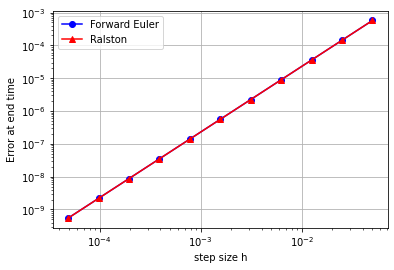

In [16]:
from matplotlib import pyplot as plt
plt.loglog(res[:,0],res[:,1],'bo-',label="Forward Euler")
plt.loglog(res[:,0],res[:,4],'r^-',label="Ralston")
plt.legend()
plt.grid(True)
plt.xlabel("step size h")
plt.ylabel("Error at end time")

Text(0, 0.5, 'Error at end time')

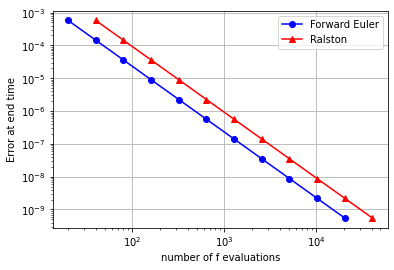

In [17]:
plt.loglog(T/res[:,0],res[:,1],'bo-',label="Forward Euler")
plt.loglog(2*T/res[:,0],res[:,4],'r^-',label="Ralston")
plt.legend()
plt.grid(True)
plt.xlabel("number of f evaluations")
plt.ylabel("Error at end time")

### A) Accurracy comparison
Although Graph 1 shows that  the approximation error converges non-linearly to zero when h tends to 0. Therefore, according to Theorem 5 we cannot ensure that the EOC for Forward Euler Method  converges to $O(h)$ as before. There is no theory in the lecture notes for Ralston therefore our results can't be contrasted. 

### B) Efficiency comparison. 
Each step of the Euler method requires a single evaluation of the right hand side function f in each step while Ralston Method requires two evaluations. Therefore, the computational cost of the method from Ralston measured by the number of evaluations of f to simulate up to a fixed time T will be twice the cost of the forward Euler method. This measure is used on the x axis
in the final Figure showing the error for a given computational cost. Despite this fact, Graph 2 shows that Ralston Method is more efficient because to attain a given error it needs less computations of f.


